In [1]:
%matplotlib inline
import sys
import os
import numpy
import scipy
from matplotlib import pyplot
print os.getcwd()
sys.path.insert(0, '../')
from filter.filters import Filter, FilterFactory, truncate

D:\audio\speaker\axiak\speakers\notebooks
Computing crc for ../filter\filters.py


In [2]:
ff = FilterFactory(48000, 1024)

Please close figure window to continue


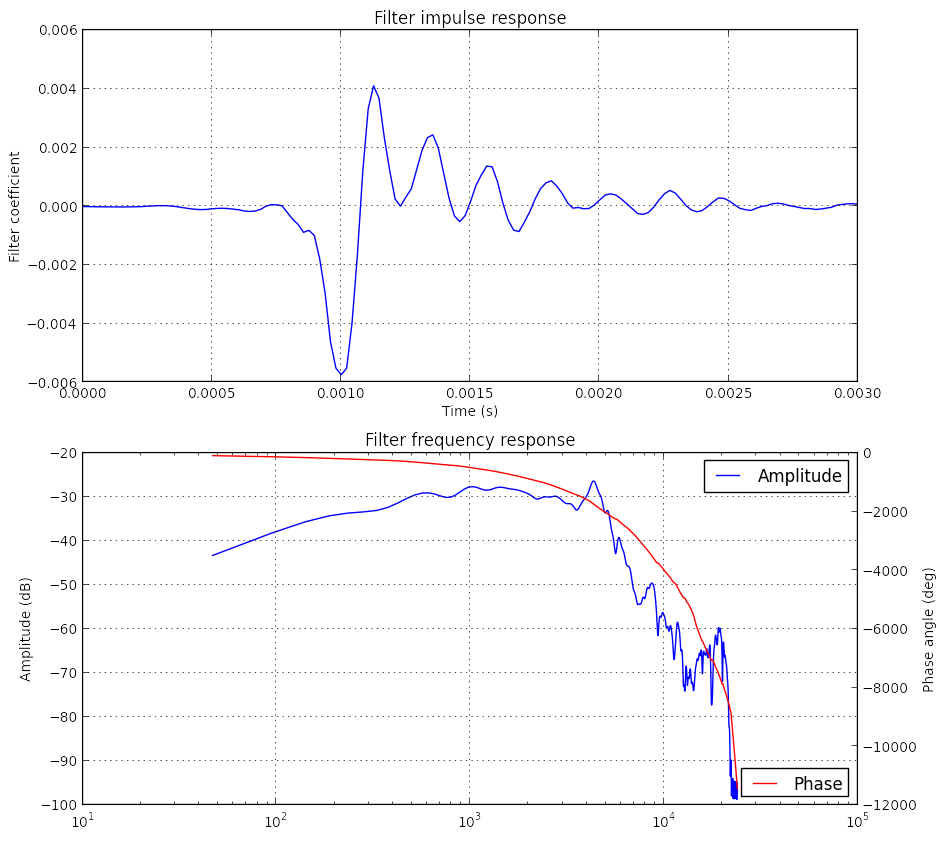

Please close figure window to continue


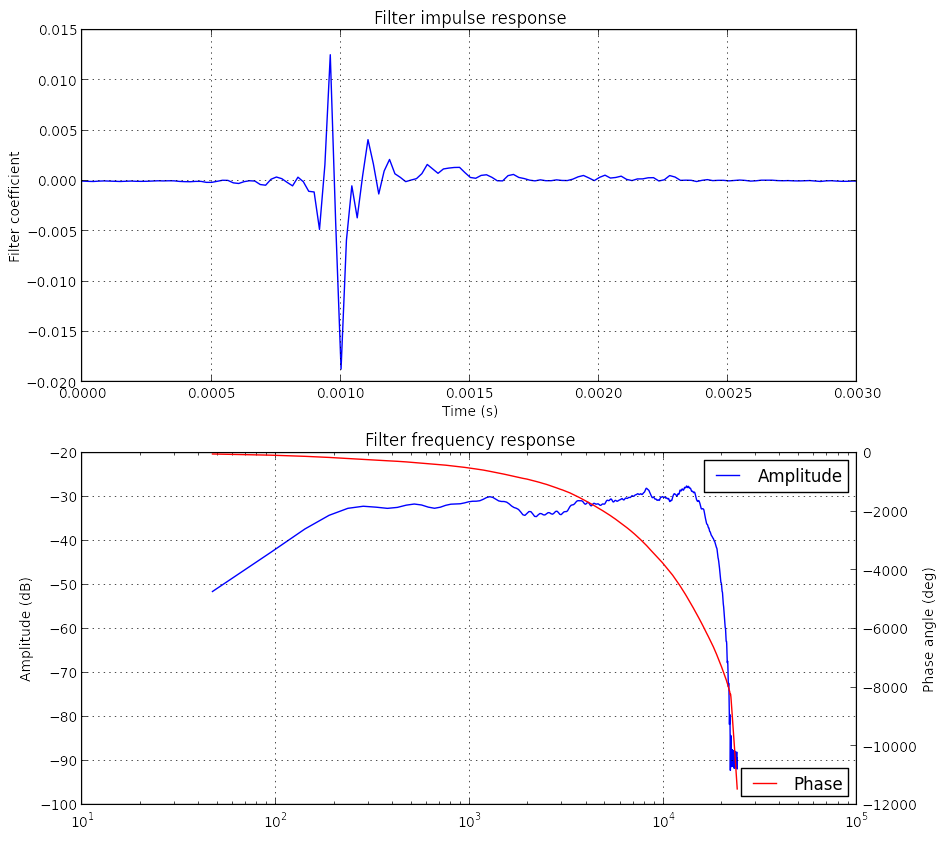

Please close figure window to continue


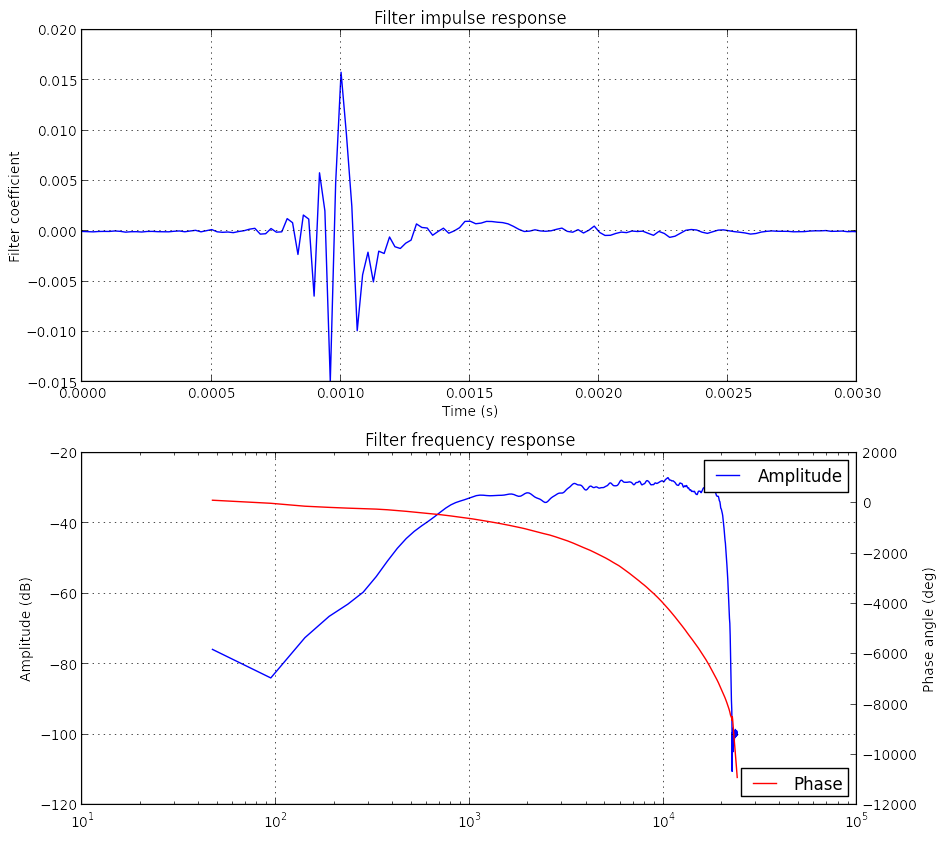

In [3]:
bass_driver = ff.measurement('../measurements/bassright.txt.gz', (-.001, 0.0031))
mid_driver = ff.measurement('../measurements/midright.txt.gz', (-.001, 0.0040))
tweeter_driver = ff.measurement('../measurements/tweeterright.txt.gz', (-.001, 0.0040))
bass_driver.plot()
mid_driver.plot()
tweeter_driver.plot()

In [4]:

def plot_system(filters, plot_sum=True, title=None):
    filter_sum = ff.nopass()
    pyplot.figure(figsize=(12, 6))
    pyplot.hold(True)
    for filt in filters:
        filter_sum += filt
    if plot_sum:
        filters_aug = filters + [filter_sum,]
    else:
        filters_aug = filters
    peak_val = -9999
    for filt in filters_aug:
        filter_size = len(filt.coefficients)
        fft_coefs = scipy.fftpack.fft(filt.coefficients)
        freq_scale = numpy.linspace(0, filt.sample_freq, filter_size + 1)[:-1]
        fft_coefs = fft_coefs[:(filter_size / 2 + 1)]
        freq_scale = freq_scale[:(filter_size) / 2 + 1]
        fr_mag = 20 * numpy.log10(numpy.abs(fft_coefs))
        pyplot.semilogx(freq_scale, fr_mag)
        peak_val = max(peak_val, numpy.max(fr_mag))
    pyplot.grid(True)
    pyplot.ylim(peak_val - 20, peak_val + 3)
    if title is not None:
        pyplot.title(title)

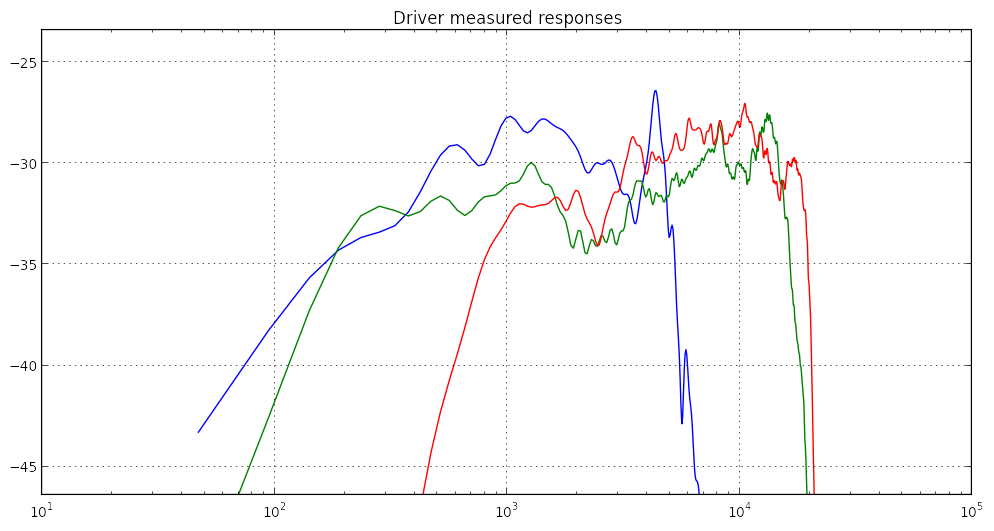

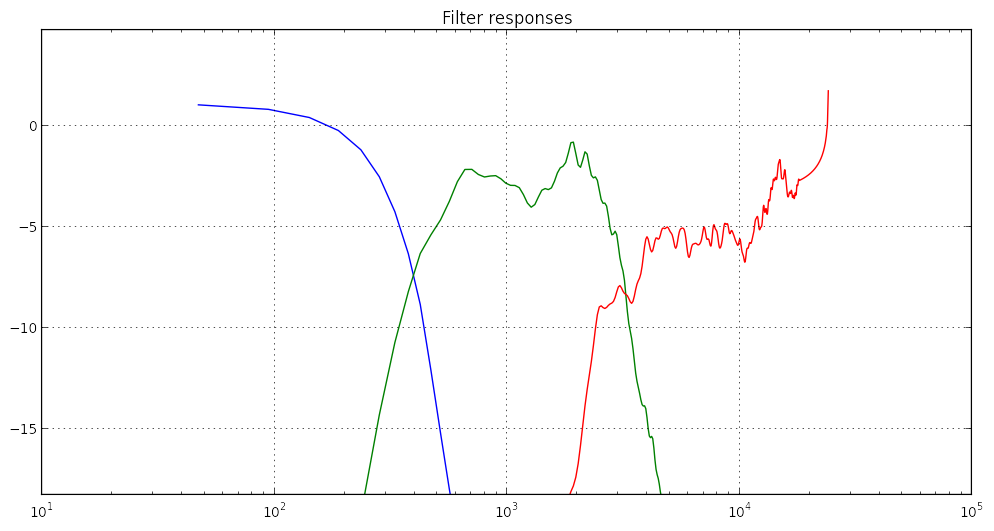

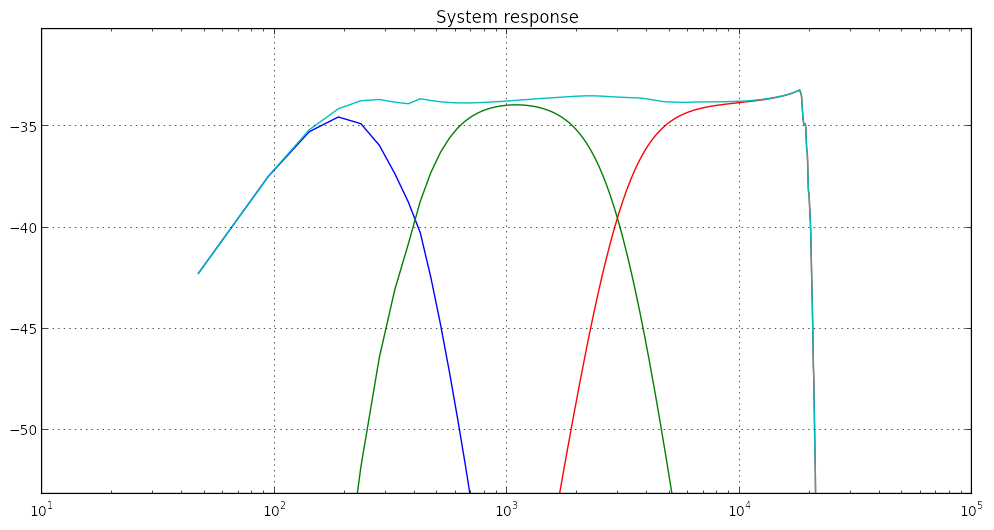

In [5]:
#   EQ will compensate for baffle effects 
#   Use the shelving filter for baffle step compensation only outside the EQ band
meas_lf_cutoff = 400
baffle_step = ff.apply_freq_limits(ff.shelf(450, -6), 0, meas_lf_cutoff)
tw_comp = ff.invert_measurement('../measurements/tweeterright.txt.gz', (-1e-3, 4e-3), (1.2e3, 1.8e4))
mid_comp = ff.invert_measurement('../measurements/midright.txt.gz', (-1e-3, 4e-3), (meas_lf_cutoff, 1.4e4))
wf_comp = ff.invert_measurement('../measurements/bassright.txt.gz', (-1e-3, 3.1e-3), (meas_lf_cutoff, 3e3))

RT2 = 0.707

mid_hp = ff.analog_hp2(400, RT2) ** 2
mid_lp = ff.analog_lp2(3000, RT2) ** 2
mid_bp = mid_hp * mid_lp

crossover = [
     wf_comp * (ff.analog_lp2(400, RT2) ** 2) * baffle_step,
     mid_comp * mid_bp * baffle_step * ff.gain(-1.0),
     tw_comp * (ff.analog_hp2(3000, RT2) ** 2) * baffle_step * ff.gain(-0.5) * ff.invert(),
]

system = [
    crossover[0] * bass_driver,
    crossover[1] * mid_driver,
    crossover[2] * tweeter_driver
]

meas_only = [bass_driver, mid_driver, tweeter_driver]

plot_system(meas_only, plot_sum=False, title='Driver measured responses')
plot_system(crossover, plot_sum=False, title='Filter responses')
plot_system(system, title='System response')